In [1]:
%matplotlib inline 

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use( 'tkagg' )
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from matplotlib import cm

import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
#assert egrid.shape == (406, 964)
import time
from impacts import distance, IMPAaCS

In [3]:
# Set the size bins
max_diameter=330
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [4]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['frequency_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

high      low  lambda_start  lambda_end  frequency_factor
005      16950000  1695000           1.0           2               0.1
005-009    855000    85500           1.1           4               0.2
010-050    146100    14610           1.2           8               0.3
050-100      8700      870           1.4          16               0.6
100+         3050      305           1.8          32               0.8

In [5]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

/home/jmframe/programs/anaconda3/envs/impacts/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


total impacts 3183005.0
impacts by diameter {'005': 2705755.0, '005-009': 381411.0, '010-050': 86429.0, '050-100': 7127.0, '100+': 2283.0}
fraction of total {'005': 0.85, '005-009': 0.12, '010-050': 0.03, '050-100': 0.0, '100+': 0.0}


/home/jmframe/programs/anaconda3/envs/impacts/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


high      low  lambda_start  lambda_end  frequency_factor  \
005      16950000  1695000           1.0           2          0.000061   
005-009    855000    85500           1.1           4          0.000274   
010-050    146100    14610           1.2           8          0.000559   
050-100      8700      870           1.4          16          0.002880   
100+         3050      305           1.8          32          0.003479   

             total  
005      2705755.0  
005-009   381411.0  
010-050    86429.0  
050-100     7127.0  
100+        2283.0

In [6]:
list_impacts_export = list(range(0,500,50))
list_impacts_export.append(499)

In [7]:
impact_boundz=5
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz])
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    Impc.do_sample_percents(n_layers=2)
    
    if it == 0:
        percent_df = pd.DataFrame(Impc.sample_percents, index=[it])
    else:
        percent_df = percent_df.append(Impc.sample_percents, ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True)
        print(percent_df.iloc[-1,:])

/home/jmframe/IMPaCS/impacts.py:313: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


45    27.029915
50    72.970085
Name: 0, dtype: float64
before bound 83.4
Average target 57.800000000000004
after bound 80.0
before bound 83.4
Average target 57.800000000000004
after bound 80.0
before bound 83.4
Average target 57.800000000000004
after bound 80.0
45          NaN
50     5.982906
53     0.534188
54    21.794872
56          NaN
58          NaN
55    11.217949
64     0.320513
48    34.829060
51     6.196581
57          NaN
65     0.427350
47    16.132479
52     0.320513
49     1.068376
59          NaN
60          NaN
61          NaN
68     0.320513
46     0.747863
63     0.106838
Name: 50, dtype: float64
before bound 84.74999999999999
Average target 58.25
after bound 80.0
before bound 84.74999999999999
Average target 58.25
after bound 80.0
before bound 84.74999999999999
Average target 58.25
after bound 80.0
before bound 84.74999999999999
Average target 58.25
after bound 80.0
before bound 92.84999999999998
Average target 60.949999999999996
after bound 80.0
before bound 92.84

self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [66.9 52.3]
mean_sio2 59.6
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [66.9 52.3]
mean_sio2 59.6
self.grid_cell_state[grid_cell][0:2] [66.9 52.3]
mean_sio2 59.6
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [70

self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [61.4 53.4]
mean_sio2 57.4
self.grid_cell_state[grid_cell][0:2] [61.4 53.4]
mean_sio2 57.4
self.grid_cell_state[grid_cell][0:2] [53.4 53.4]
mean_sio2 53.4
self.grid_cell_state[grid_cell][0:2] [53.4 53.4]
mean_sio2 53.4
self.grid_cell_state[grid_cell][0:2] [60.7 53.4]
mean_sio2 57.05
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [5

self.grid_cell_state[grid_cell][0:2] [47.1 40. ]
mean_sio2 43.55
self.grid_cell_state[grid_cell][0:2] [47.1 40. ]
mean_sio2 43.55
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 47. ]
mean_sio2 46.75
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [41.7 47.8]
mean_sio2 44.75
self.grid_cell_state[grid_cell][0:2]

self.grid_cell_state[grid_cell][0:2] [80.  51.2]
mean_sio2 65.6
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [47.8 48.9]
mean_sio2 48.349999999999994
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [49.6 40. ]
mean_sio2 44.8
self.grid_cell_state[grid_cell][0:2] [49.6 40. ]
mean_sio2 44.8
self.grid_cell_state[grid_cell][0:2] [49.6 40. ]
mean_sio2 44.8
self.grid_cell_state[grid_cell][0:2] [49.6 40. ]
mean_sio2 44.8
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [53.7 47.9]
mean_sio2 50.8
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_

self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [49.9 49.9]
mean_sio2 49.9
self.grid_cell_state[grid_cell][0:2] [49.9 49.9]
mean_sio2 49.9
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [47. 47.]
mean_sio2 47.0
self.grid_cell_state[grid_cell][0:2] [47. 47.]
mean_sio2 47.0
self.grid_cell_state[grid_cell][0:2] [47.1 40.

self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [49.2 49.2]
mean_sio2 49.2
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47

self.grid_cell_state[grid_cell][0:2] [49.2 46.3]
mean_sio2 47.75
self.grid_cell_state[grid_cell][0:2] [49.2 46.3]
mean_sio2 47.75
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [

self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47

before bound 81.49999999999999
Average target 57.166666666666664
after bound 80.0
before bound 81.49999999999999
Average target 57.166666666666664
after bound 80.0
before bound 81.49999999999999
Average target 57.166666666666664
after bound 80.0
before bound 81.49999999999999
Average target 57.166666666666664
after bound 80.0
self.grid_cell_state[grid_cell][0:2] [47.1 51.4]
mean_sio2 49.25
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell]

self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [70.1 52.3]
mean_sio2 61.199999999999996
self.grid_cell_state[grid_cell][0:2] [70.1 50.7]
mean_sio2 60.4
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [55.5 46.5]
mean_sio2 51.0
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [44.9 46.7]
mean_sio2 45.8
self.grid_cell_state[grid_

self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 5

mean_sio2 51.0
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [44.9 46.7]
mean_sio2 45.8
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid

mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [51.2 51.2]
mean_sio2 51.2
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [47.8 48.9]
mean_sio2 48.349999999999994
self.grid_cell_state[grid_cell][0:2] [47.8 48.9]
mean_sio2 48.349999999999994
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [60.4 48.2]
mean_sio2 54.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52

self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [47.2 47.2]
mean_sio2 47.2
self.grid_cell_state[grid_cell][0:2] [47.2 47.2]
mean_sio2 47.2
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51

self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49.3 49.3]
mean_sio2 49.3
self.grid_cell_state[grid_cell][0:2] [49

mean_sio2 51.599999999999994
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [56.9 48. ]
mean_sio2 52.45
self.grid_cell_state[grid_cell][0:2] [56.9 48. ]
mean_sio2 52.45
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cel

self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [54.7 47.6]
mean_sio2 51.150000000000006
self.grid_cell_state[grid_cell][0:2] [54.7 47.6]
mean_sio2 51.150000000000006
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [52.8 47.6]
mean_sio2 50.2
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_ce

mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [46.3 46.3]
mean_sio2 46.3
self.grid_cell_state[grid_cell][0:2] [46.3 46.3]
mean_sio2 46.3
self.grid_cell_state[grid_cell][0:2] [46.3 46.3]
mean_sio2 46.3
self.grid_cell_state[grid_cell][0:2] [46.3 46.3]
mean_sio2 46.3
self.grid_cell_state[grid

self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [46

self.grid_cell_state[grid_cell][0:2] [47.1 51.4]
mean_sio2 49.25
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [54.9 48.3]
mean_sio2 51.599999999999994
self.grid_cell_state[grid

self.grid_cell_state[grid_cell][0:2] [66.9 52.3]
mean_sio2 59.6
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [70.1 52.3]
mean_sio2 61.199999999999996
self.grid_cell_state[grid_cell][0:2] [70.1 47.8]
mean_sio2 58.949999999999996
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_

self.grid_cell_state[grid_cell][0:2] [47.1 51.4]
mean_sio2 49.25
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [54.9 48.3]
mean_sio2 51.599999999999994
self.grid_cell_state[grid

self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.7 47.7]
mean_sio2 47.7
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [47.8 47.8]
mean_sio2 47.8
self.grid_cell_state[grid_cell][0:2] [66.9 52.3]
mean_sio2 59.6
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [

self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [48.9 48.9]
mean_sio2 48.9
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [70.2 52.3]
mean_sio2 61.25
self.grid_cell_state[grid_cell][0:2] [70.2 50.7]
mean_sio2 60.45
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [

self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [49.9 49.9]
mean_sio2 49.9
self.grid_cell_state[grid_cell][0:2] [49.9 49.9]
mean_sio2 49.9
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [46.7 46.7]
mean_sio2 46.7
self.grid_cell_state[grid_cell][0:2] [48. 48.]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [47. 47.]
mean_sio2 47.0
self.grid_cell_state[grid_cell][0:2] [47. 47.]
mean_sio2 47.0
self.grid_cell_state[grid_cell][0:2] [47.1 40. ]
mean_sio2 43.55
self.grid_cell_state[grid_cell][0:2] [47.1 40. ]
mean_sio2 43.55
self.grid_cell_state[grid_cell][0:2] [47.1 40. ]
mean_sio2 43.55
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 

self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [75.1 51.7]
mean_sio2 63.4
self.grid_cell_state[grid_cell][0:2] [51.7 51.7]
mean_sio2 51.7
self.grid_cell_state[grid_cell][0:2] [51.7 51.7]
mean_sio2 51.7
self.grid_cell_state[grid_cell][0:2] [80.  51.7]
mean_sio2 65.85
self.grid_cell_state[grid_cell][0:2] [80.  51.7]
mean_sio2 65.85
self.grid_cell_state[grid_cell][0:2] [51.7 51.7]
mean_sio2 51.7
self.grid_cell_state[grid_cell][0:2] [73.3 50.7]
mean_sio2 62.0
self.grid_cell_state[grid_cell][0:2] [73.3 50.7]
mean_sio2 62.0
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [50.7 50.7]
mean_sio2 50.7
self.grid_cell_state[grid_cell][0:2] [79.2 50.7]
mean_sio2 64.95
self.grid_cell_state[grid_cell][0:2] [79.2 50.7]
mean_sio2 64.95
self.grid_cell_state[grid_cell][0:2]

mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.2 46.2]
mean_sio2 46.2
self.grid_cell_state[grid_cell][0:2] [46.3 47.2]
mean_sio2 46.75
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [47.1 47.1]
mean_sio2 47.1
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[grid_cell][0:2] [51.5 51.5]
mean_sio2 51.5
self.grid_cell_state[gri

self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [47.6 47.6]
mean_sio2 47.6
self.grid_cell_state[grid_cell][0:2] [48.6 48.6]
mean_sio2 48.6
self.grid_cell_state[grid_cell][0:2] [47.9 47.9]
mean_sio2 47.9
self.grid_cell_state[grid_cell][0:2] [80.  52.8]
mean_sio2 66.4
self.grid_cell_state[grid_cell][0:2] [52.8 52.8]
mean_sio2 52.8
self.grid_cell_state[grid_cell][0:2] [52.8 52.8]
mean_sio2 52.8
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [50.4 50.4]
mean_sio2 50.4
self.grid_cell_state[grid_cell][0:2] [50.2 50.2]
mean_sio2 50.2
self.grid_cell_state[grid_cell][0:2] [52

before bound 83.09999999999998
Average target 57.699999999999996
after bound 80.0
self.grid_cell_state[grid_cell][0:2] [47.1 51.4]
mean_sio2 49.25
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [49.8 49.8]
mean_sio2 49.8
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[grid_cell][0:2] [48.3 48.3]
mean_sio2 48.3
self.grid_cell_state[

self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [80.  52.3]
mean_sio2 66.15
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [52.3 52.3]
mean_sio2 52.3
self.grid_cell_state[grid_cell][0:2] [70.1 52.3]
mean_sio2 61.199999999999996
self.grid_cell_state[grid_cell][0:2] [70.1 47.8]
mean_sio2 58.949999999999996
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [49.5 46.5]
mean_sio2 48.0
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_cell_state[grid_cell][0:2] [46.5 46.5]
mean_sio2 46.5
self.grid_

45     2.136752
50     8.547009
53    12.393162
54     1.282051
56     0.320513
58     0.961538
55     0.106838
64     0.213675
48    20.299145
51     4.273504
57     0.320513
65     0.641026
47    21.047009
52    12.393162
49     8.653846
59     0.106838
60     0.747863
61     0.854701
68          NaN
46     0.747863
63          NaN
62     0.961538
66     0.534188
67     0.854701
42          NaN
44     1.282051
43     0.320513
Name: 499, dtype: float64


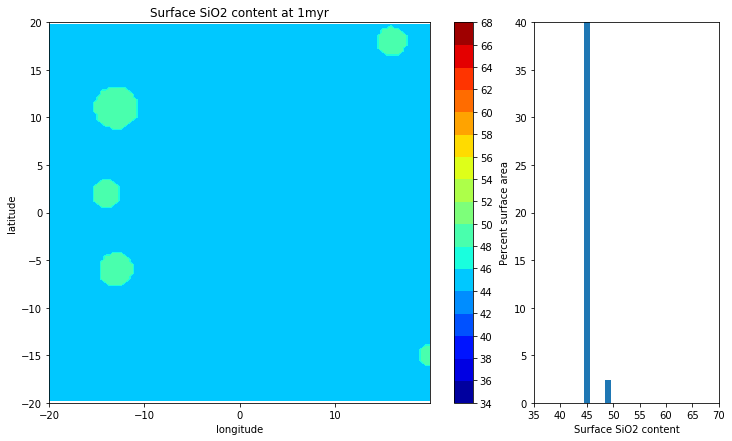

45    97.557703
49     2.442297
Name: 0, dtype: float64


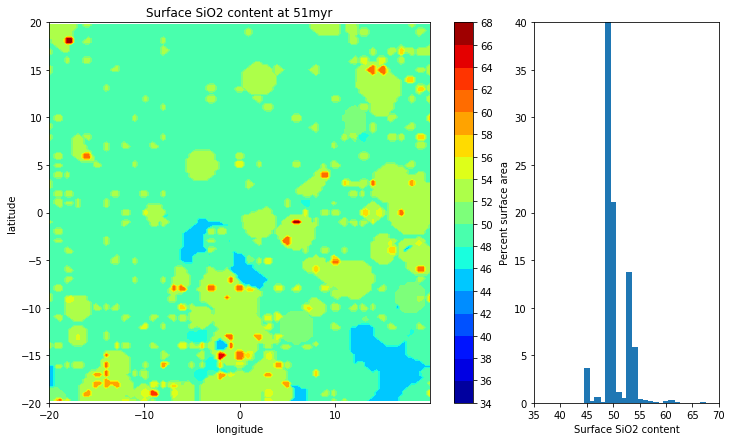

45     3.703704
49    51.583468
48     0.040258
50    21.061460
51     1.133924
53    13.714439
43     0.006710
46     0.140902
47     0.597155
54     5.817230
52     0.496511
56     0.281804
58     0.067096
55     0.389157
57     0.234836
41          NaN
61     0.328771
60     0.201288
64     0.020129
59     0.026838
62     0.093935
65     0.020129
67     0.040258
Name: 50, dtype: float64


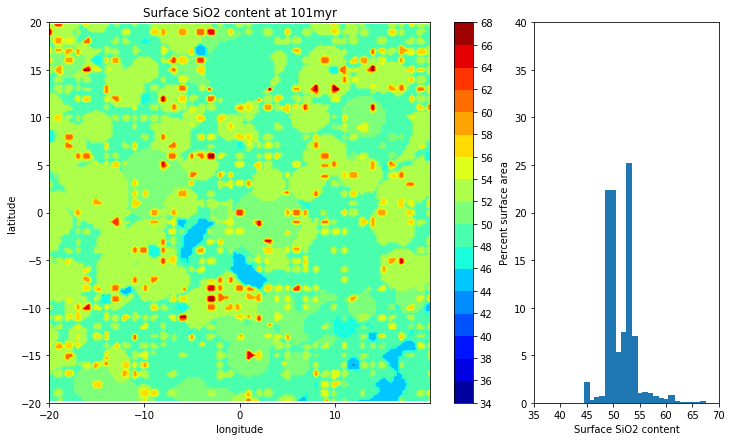

45     2.200751
49    22.376543
48     0.691090
50    22.376543
51     5.293881
53    25.221417
43     0.020129
46     0.328771
47     0.590446
54     7.031669
52     7.494632
56     1.140633
58     0.684380
55     0.986312
57     1.006441
41          NaN
61     0.872249
60     0.449544
64     0.067096
59     0.503221
62     0.207998
65     0.120773
67     0.167740
63     0.100644
42          NaN
66     0.040258
44     0.026838
Name: 100, dtype: float64


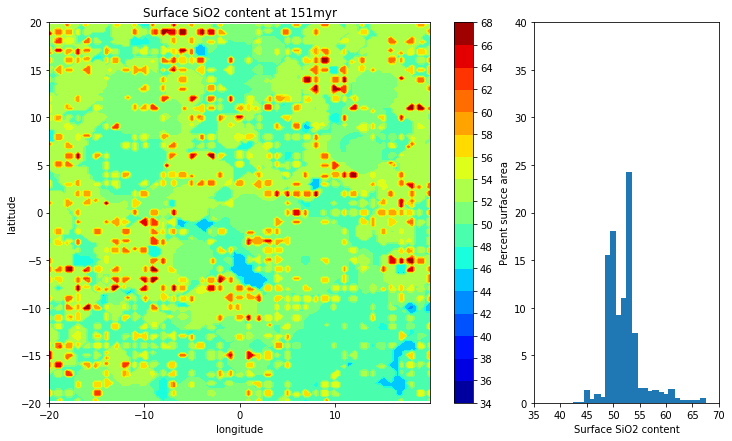

45     1.321793
49    15.499195
48     0.623994
50    18.048846
51     9.245840
53    24.261943
43     0.033548
46     0.429415
47     0.919216
54     7.347021
52    11.010467
56     1.509662
58     1.294954
55     1.549919
57     1.288245
41          NaN
61     1.435856
60     0.932636
64     0.248256
59     1.154053
62     0.489801
65     0.288513
67     0.509930
63     0.248256
42          NaN
66     0.268384
44     0.040258
Name: 150, dtype: float64


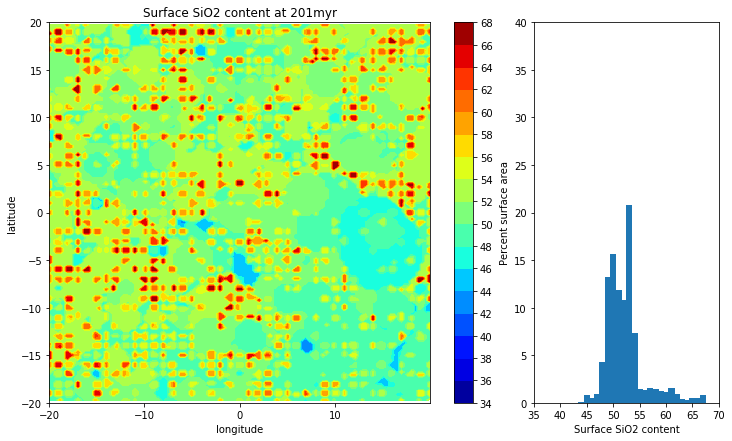

45     0.865539
49    13.238057
48     4.300859
50    15.687064
51    11.808910
53    20.806495
43     0.013419
46     0.476382
47     0.966184
54     7.333602
52    10.822598
56     1.355341
58     1.496243
55     1.476114
57     1.583468
41     0.013419
61     1.596887
60     1.180891
64     0.322061
59     1.261406
62     0.972893
65     0.536769
67     0.845411
63     0.389157
42          NaN
66     0.523349
44     0.127483
Name: 200, dtype: float64


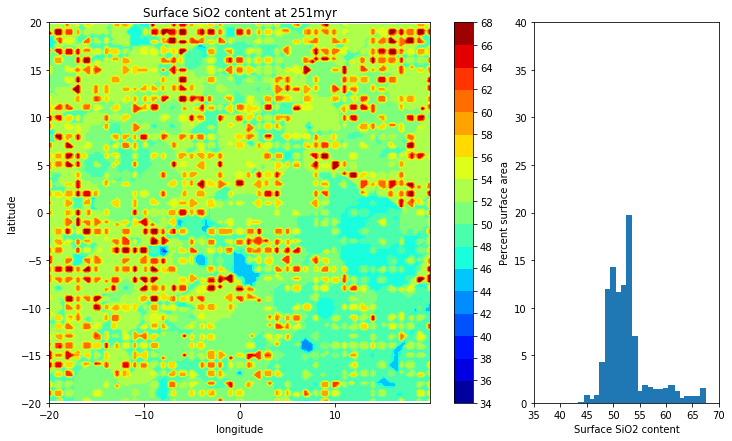

45     0.778315
49    11.916264
48     4.294149
50    14.325013
51    11.641170
53    19.759796
43     0.013419
46     0.429415
47     0.825282
54     6.971283
52    12.372517
56     1.831723
58     1.422437
55     1.281535
57     1.650564
41          NaN
61     1.912238
60     1.583468
64     0.691090
59     1.476114
62     1.214439
65     0.724638
67     1.536500
63     0.523349
42     0.006710
66     0.677670
44     0.120773
40     0.020129
Name: 250, dtype: float64


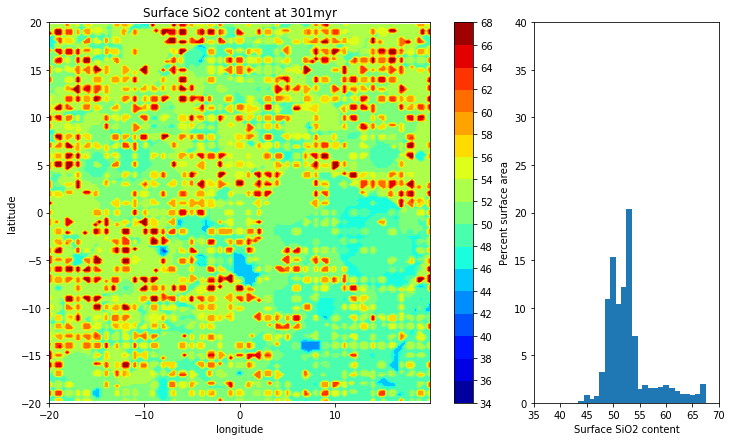

45     0.838701
49    10.869565
48     3.227322
50    15.378422
51    10.406602
53    20.363661
43     0.013419
46     0.422705
47     0.751476
54     7.058508
52    12.184648
56     1.865271
58     1.556629
55     1.409018
57     1.549919
41          NaN
61     1.596887
60     1.831723
64     0.946055
59     1.610306
62     1.207729
65     0.865539
67     1.986044
63     0.899087
42     0.006710
66     0.959474
44     0.174450
40     0.020129
Name: 300, dtype: float64


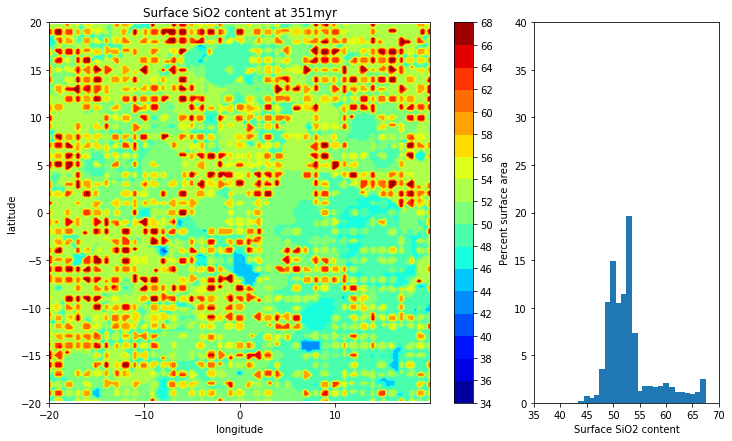

45     0.724638
49    10.621310
48     3.576221
50    14.861782
51    10.513956
53    19.585346
43     0.013419
46     0.462963
47     0.845411
54     7.380569
52    11.473430
56     1.791465
58     1.630435
55     1.201020
57     1.724369
41          NaN
61     1.643854
60     2.046430
64     1.053408
59     1.818304
62     1.160762
65     0.919216
67     2.489265
63     1.086957
42     0.006710
66     1.174181
44     0.174450
40     0.020129
Name: 350, dtype: float64


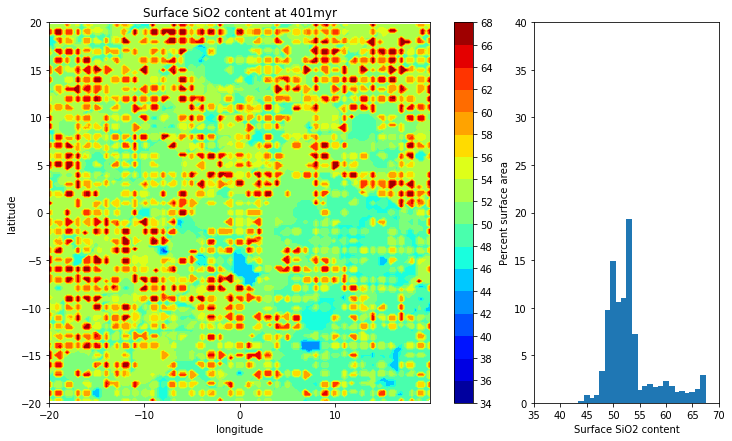

45     0.798443
49     9.775899
48     3.314546
50    14.888621
51    10.607890
53    19.283414
43     0.013419
46     0.483092
47     0.865539
54     7.219538
52    11.064144
56     1.764627
58     1.650564
55     1.294954
57     1.979334
41          NaN
61     1.778046
60     2.254428
64     1.053408
59     1.791465
62     1.154053
65     1.154053
67     2.911970
63     1.207729
42     0.006710
66     1.482823
44     0.181159
40     0.020129
Name: 400, dtype: float64


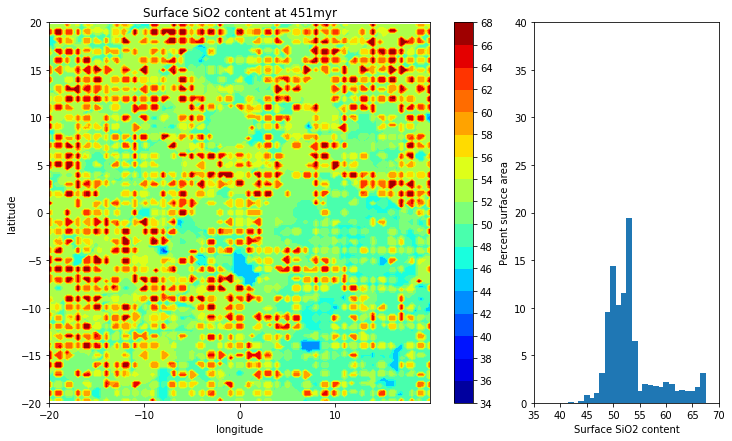

45     0.818572
49     9.534353
48     3.160225
50    14.385400
51    10.332797
53    19.410896
43          NaN
46     0.496511
47     0.979603
54     6.541868
52    11.567364
56     1.939077
58     1.798175
55     1.241278
57     1.845142
41     0.013419
61     1.965915
60     2.180623
64     1.274826
59     1.690821
62     1.227858
65     1.261406
67     3.166935
63     1.321793
42     0.033548
66     1.617016
44     0.174450
40     0.020129
Name: 450, dtype: float64


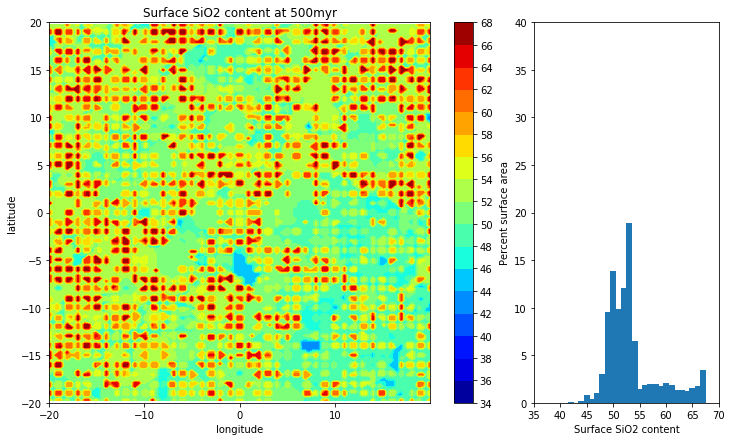

45     0.818572
49     9.507515
48     3.066291
50    13.875470
51     9.876543
53    18.867418
43          NaN
46     0.429415
47     1.039989
54     6.461353
52    12.050456
56     1.912238
58     1.999463
55     1.409018
57     1.979334
41     0.013419
61     1.912238
60     2.126946
64     1.274826
59     1.737789
62     1.308374
65     1.543210
67     3.468867
63     1.328502
42     0.033548
66     1.784756
44     0.174450
40          NaN
Name: 499, dtype: float64


In [17]:
impact_boundz=20
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz])
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    Impc.do_sample_percents(n_layers=2)
    
    if it == 0:
        percent_df = pd.DataFrame(Impc.sample_percents, index=[it])
    else:
        percent_df = percent_df.append(Impc.sample_percents, ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True)
        print(percent_df.iloc[-1,:])

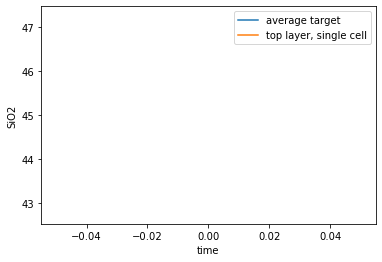

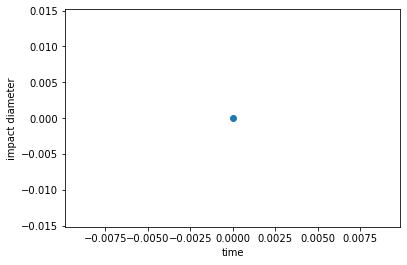

In [16]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

In [15]:
n_x = egrid.londim.shape[0]
n_y = egrid.latdim.shape[0]
z = np.zeros([n_x, n_y])
for i, ilon in enumerate(egrid.londim):
    for j, ilat in enumerate(egrid.latdim):
        grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
        z[i, j] = np.mean(Impc.grid_cell_state[grid_cell][0:2])

X, Y = np.meshgrid(egrid.londim, egrid.latdim)

KeyError: '-179.8133 83.632'

In [ ]:
z

In [ ]:
# fig1, ax1 = plt.subplots(constrained_layout=True)
# fig1.clim(30, 65)
# cs = ax1.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
# cs.set_clim(30, 65)
# fig1.colorbar(cs)
# cbar = fig1.colorbar(cs, boundaries=[30,65], cmap = cs)
# cbar.ax.set_ylabel('percent SiO2')
#cbar.set_clim(30,65)
plt.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
plt.clim(vmin=30, vmax=65)
cb = plt.colorbar()
cb.set_clim(vmin=30, vmax=65)
plt.title('top 6-meter sio2 at time {}myr'.format(int(Impc.sim_time/1000000)))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()
plt.close()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

# 10 X impacts teste cast

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 330, 330, 330, 330, 330, 330, 330, 330, 330,
                         73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
                         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                         10, 10,  10,  10,  10,  10,  10,  10,  10,  10, 
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()